In [38]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# フォントを Meiryo に設定
plt.rcParams['font.family'] = 'Meiryo'

# CSV読み込み
file_path = "zaiko.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')

# 拠点所番地が空白（NaN または 空文字）のデータを除外
df= df[~df['拠点所番地'].isnull() & (df['拠点所番地'] != '')]

# 日時列をdatetime型に変換
df['日時'] = pd.to_datetime(df['日時'])

# 品番と拠点所番地ごとにグループ化し、日時順に並べる
df_sorted = df.sort_values(by=['品番', '拠点所番地', '日時']).copy()

# 1時間前の在庫数（箱）を取得
df_sorted['1時間前の在庫数（箱）'] = df_sorted.groupby(['品番', '拠点所番地'])['在庫数（箱）'].shift(1)

# 予測在庫を計算
df_sorted['予測在庫（箱）'] = df_sorted['1時間前の在庫数（箱）'] + df_sorted['入庫数（箱）']

# 一致・不一致判定
df_sorted['一致'] = df_sorted['予測在庫（箱）'] == df_sorted['在庫数（箱）']

# 品番と拠点所番地ごとに集計
group_cols = ['品番', '拠点所番地']

品番拠点別集計 = df_sorted.groupby(group_cols).agg(
    一致件数=('一致', lambda x: (x == True).sum()),
    不一致件数=('一致', lambda x: (x == False).sum()),
    平均入庫数箱=('入庫数（箱）', 'mean'),
    平均出庫数箱=('出庫数（箱）', 'mean'),
    平均在庫数箱=('在庫数（箱）', 'mean')
).reset_index()

# 全体件数と一致率を追加
品番拠点別集計['全体件数'] = 品番拠点別集計['一致件数'] + 品番拠点別集計['不一致件数']
品番拠点別集計['一致率（%）'] = (品番拠点別集計['一致件数'] / 品番拠点別集計['全体件数'] * 100).round(2)

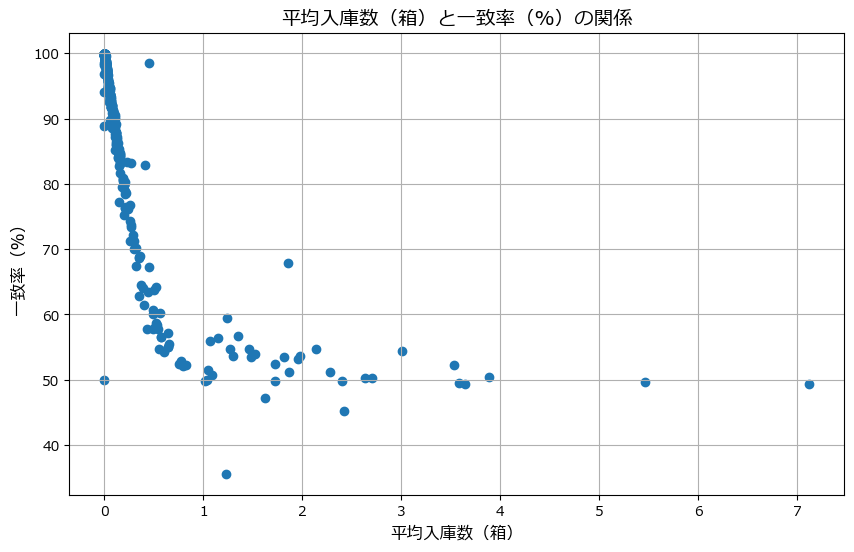

In [39]:
# ✅ グラフ描画
plt.figure(figsize=(10, 6))
plt.scatter(品番拠点別集計['平均入庫数箱'], 品番拠点別集計['一致率（%）'])

plt.xlabel('平均入庫数（箱）', fontsize=12)
plt.ylabel('一致率（%）', fontsize=12)
plt.title('平均入庫数（箱）と一致率（%）の関係', fontsize=14)

plt.grid(True)
plt.show()

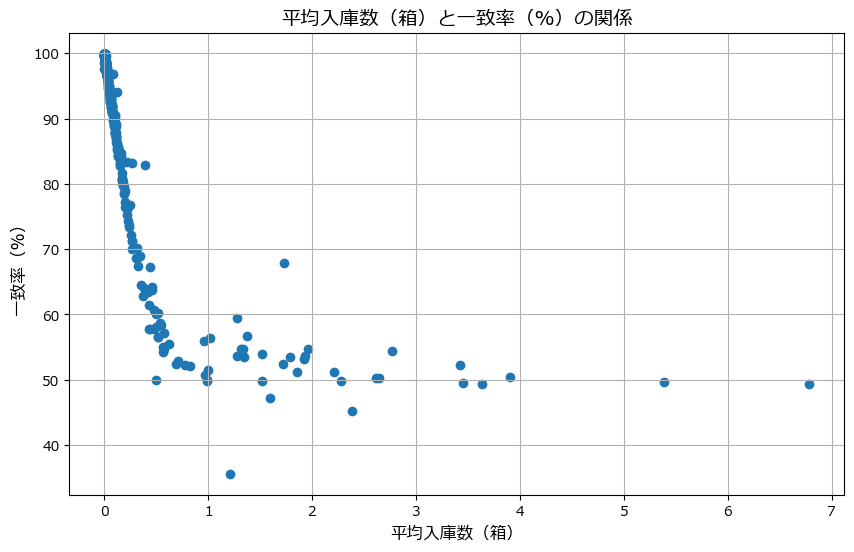

In [40]:
# ✅ グラフ描画
plt.figure(figsize=(10, 6))
plt.scatter(品番拠点別集計['平均出庫数箱'], 品番拠点別集計['一致率（%）'])

plt.xlabel('平均入庫数（箱）', fontsize=12)
plt.ylabel('一致率（%）', fontsize=12)
plt.title('平均入庫数（箱）と一致率（%）の関係', fontsize=14)

plt.grid(True)
plt.show()

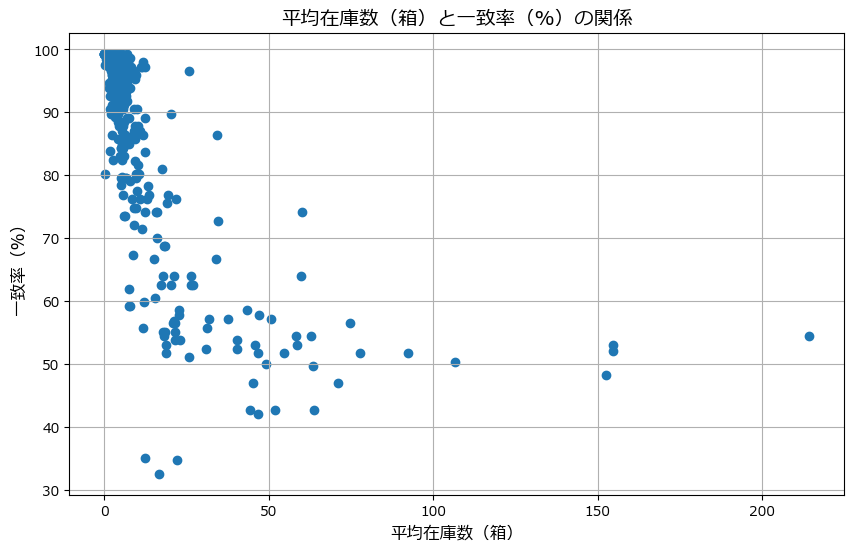

In [29]:
# ✅ グラフ描画
plt.figure(figsize=(10, 6))
plt.scatter(品番拠点別集計['平均在庫数箱'], 品番拠点別集計['一致率（%）'])

plt.xlabel('平均在庫数（箱）', fontsize=12)
plt.ylabel('一致率（%）', fontsize=12)
plt.title('平均在庫数（箱）と一致率（%）の関係', fontsize=14)

plt.grid(True)
plt.show()

✅ 一致率カテゴリ別のユニーク品番数（10%ごと・高い%が左）
   一致率カテゴリ  ユニーク品番数
0  90-100%      314
1   80-90%       60
2   70-80%       23
3   60-70%       16
4   50-60%       41
5   40-50%       10
6   30-40%        1
7   20-30%        0
8   10-20%        0
9    0-10%        0


C:\Users\chach\AppData\Local\Temp\ipykernel_42064\2172395662.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  一致率別ユニーク品番数 = 品番拠点別集計.groupby('一致率カテゴリ')['品番'].nunique().reset_index(name='ユニーク品番数')


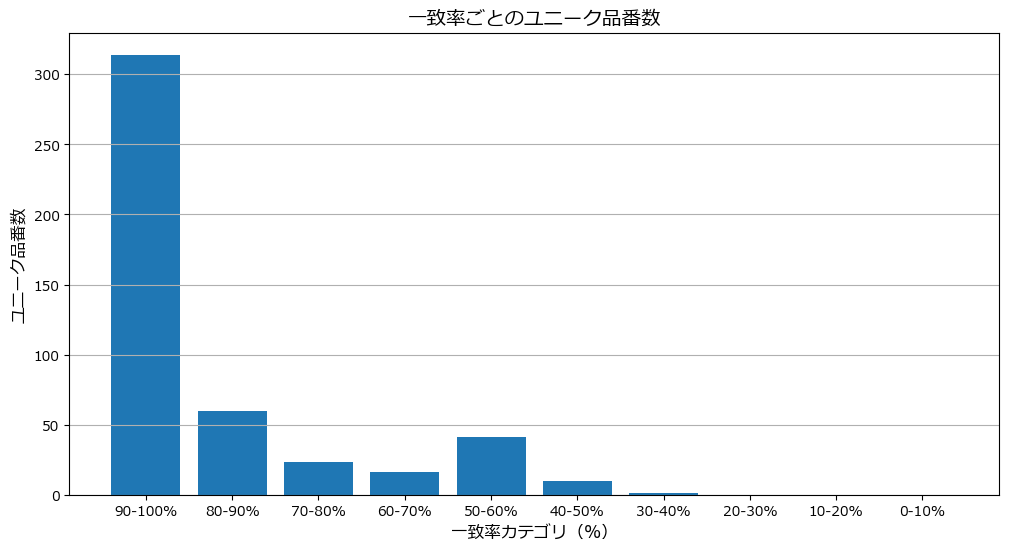

In [41]:
# 一致率を 0%-10%-20%-...-100% の等間隔で分ける
bins = list(range(0, 110, 10))  # 0, 10, 20, ..., 100
labels = [f'{i}-{i+10}%' for i in bins[:-1]]

# カテゴリ列を作成
品番拠点別集計['一致率カテゴリ'] = pd.cut(品番拠点別集計['一致率（%）'], bins=bins, labels=labels, right=False)

# 各カテゴリのユニークな品番数を集計
一致率別ユニーク品番数 = 品番拠点別集計.groupby('一致率カテゴリ')['品番'].nunique().reset_index(name='ユニーク品番数')

# ✅ 一致率カテゴリの順序を逆にする（大きい%が左）
一致率別ユニーク品番数 = 一致率別ユニーク品番数.iloc[::-1].reset_index(drop=True)

# ✅ 結果表示
print("✅ 一致率カテゴリ別のユニーク品番数（10%ごと・高い%が左）")
print(一致率別ユニーク品番数)

# ======================================
# ✅ グラフ描画（棒グラフ・高い%が左）
# ======================================
plt.figure(figsize=(12, 6))
plt.bar(一致率別ユニーク品番数['一致率カテゴリ'], 一致率別ユニーク品番数['ユニーク品番数'])

plt.xlabel('一致率カテゴリ（%）', fontsize=12)
plt.ylabel('ユニーク品番数', fontsize=12)
plt.title('一致率ごとのユニーク品番数', fontsize=14)

plt.grid(axis='y')
plt.show()

In [42]:
全品番拠点組み合わせ数 = df.groupby(['品番', '拠点所番地']).ngroups

print(f"✅ 品番✕拠点所番地のユニークな組み合わせ数: {全品番拠点組み合わせ数}")

✅ 品番✕拠点所番地のユニークな組み合わせ数: 470


In [22]:
df.groupby(['品番', '拠点所番地'])

In [43]:
# 品番と拠点所番地のユニークな組み合わせを取得
品番拠点ユニーク = df[['品番', '拠点所番地']].drop_duplicates().reset_index(drop=True)

# ✅ 最初の10件だけ表示（一覧の確認）
print("✅ ユニークな品番 × 拠点所番地 一覧（最初の10件）")
print(品番拠点ユニーク.head(10))

# ✅ 組み合わせの総数を表示
print(f"\n✅ 全ユニークな品番×拠点所番地の組み合わせ数: {len(品番拠点ユニーク)}")


✅ ユニークな品番 × 拠点所番地 一覧（最初の10件）
            品番  拠点所番地
0  82125ECE040  30510
1  82125ECE030  30405
2  G9351ECB010  20409
3  82125ECB020  50408
4  82125ECC020  50411
5  82125ECE020  30404
6  G9351ECE010  20406
7   G21E176021  10668
8  35080ECB010  30476
9  35080ECE010  30472

✅ 全ユニークな品番×拠点所番地の組み合わせ数: 470


In [44]:
品番拠点ユニーク.to_csv('ユニーク品番一覧.csv', index=False, encoding='utf-8-sig')

In [45]:
# 日時列の最小値と最大値を取得
最小日時 = df['日時'].min()
最大日時 = df['日時'].max()

# ✅ 結果表示
print(f"✅ 日時の最小値（最も古い日）: {最小日時}")
print(f"✅ 日時の最大値（最新の日）: {最大日時}")

✅ 日時の最小値（最も古い日）: 2024-03-01 00:00:00
✅ 日時の最大値（最新の日）: 2024-08-31 00:00:00
